In [1]:
import numpy as np
import torch
from tqdm import tqdm
from time import time

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Data generation

In [2]:
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 10000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

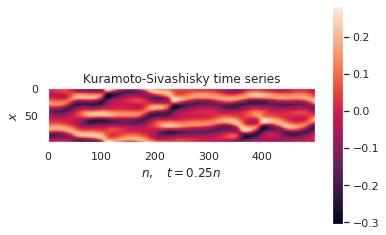

In [3]:
N_plot = 500
u_plot = u[:N_plot,:]

plt.figure()
plt.imshow(u_plot.T)
plt.colorbar()
plt.grid(b=None)
plt.xlabel(r"$n, \quad t={:}n$".format(dt))
plt.ylabel(r"$x$")
plt.title("Kuramoto-Sivashisky time series");

# Reservoir Computing timing benchmark

In [4]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

n_curves = 10
n_res_range = np.logspace(2, 4, num=n_curves, dtype=int)
input_scale = 0.01
res_scale = 0.8

n_p = len(n_res_range)
init_time = np.zeros((n_p, 1))
forward_time = np.zeros((n_p, 1))
train_time = np.zeros((n_p, 1))
pred_time = np.zeros((n_p, 1))
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t, initial_state=initial_state).to(device)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train, alpha=1e-5)
    torch.cuda.synchronize()
    train_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
    pred_output_test = Xtest @ output_w
    torch.cuda.synchronize()
    pred_time[i] = time() - start

3it [00:12,  4.30s/it]

KeyboardInterrupt: 

In [ ]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/200522_time_rc_kslen1e4_singleout', times)

# Structured Reservoir Computing

In [5]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

n_curves = 5
first_pow = 8
last_pow = 15  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 0.01
res_scale = 0.8

n_p = len(n_res_range)
init_time = np.zeros((n_p, 1))
forward_time = np.zeros((n_p, 1))
train_time = np.zeros((n_p, 1))
pred_time = np.zeros((n_p, 1))
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', random_projection='structured')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t, initial_state=initial_state).to(device)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train, alpha=1e-5)
    torch.cuda.synchronize()
    train_time[i] = time() - start
    
    start = time()
    torch.cuda.synchronize()
    Xtest = model.forward(u_test_t, initial_state=initial_state).to(device)
    pred_output_test = Xtest @ output_w
    torch.cuda.synchronize()
    pred_time[i] = time() - start


0it [00:00, ?it/s]
1it [00:06,  6.31s/it]
2it [00:12,  6.40s/it]

KeyboardInterrupt: 

In [ ]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/200522_time_src_kslen1e4_singleout', times)

# Recursive kernels

In [10]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon = 10
out_train = torch.roll(u_train_t, -pred_horizon, dims=0)
out_test = torch.roll(u_test_t, -pred_horizon, dims=0)

input_scale = 0.01
res_scale = 0.8
n_iter = 50

start = time()
torch.cuda.synchronize()
model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=n_iter)
torch.cuda.synchronize()
init_time = time() - start
start = time()
torch.cuda.synchronize()
K = model.forward(u_train_t).to(device)
torch.cuda.synchronize()
forward_time = time() - start

start = time()
torch.cuda.synchronize()
output_w = model.train(K, out_train[n_iter-1:, :], alpha=1e-5)
torch.cuda.synchronize()
train_time = time() - start

start = time()
torch.cuda.synchronize()
Ktest, _, _ = model.forward_test(u_train_t, u_test_t)
pred_output_test = Ktest @ output_w
torch.cuda.synchronize()
pred_time = time() - start

In [ ]:
times = np.concatenate((init_time, forward_time, train_time, pred_time))
np.save('out/200522_time_rk_kslen1e4_singleout', times)